In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.gan import *
import torch

# 读取数据

In [2]:
data = untar_data(URLs.MNIST)

In [3]:
data.ls()

[PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/testing'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training')]

In [4]:
(data / 'training').ls()

[PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/1')]

## 假设我们对生成数字5很感兴趣

In [5]:
focus_num = '5'

In [6]:
path = data/'training'/focus_num

In [7]:
focus_imgs = list(path.glob('*.png'))

In [8]:
focus_imgs[:3]

[PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/5/19858.png'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/5/14183.png'),
 PosixPath('/home/liangjiaxi/.fastai/data/mnist_png/training/5/13532.png')]

In [9]:
noise_dim = 100
bs = 128
img_size = 64
# 确保图片大小是2的幂次
data = GANItemList.from_folder(path, noise_sz=noise_dim) \
               .split_none()\
               .label_from_func(noop) \
               .transform(size = img_size, tfm_y=True) \
               .databunch(bs=bs)

### 看出来，我们的数据是 通道为3

In [10]:
data.train_ds[0]

(NoisyItem , Image (3, 64, 64))

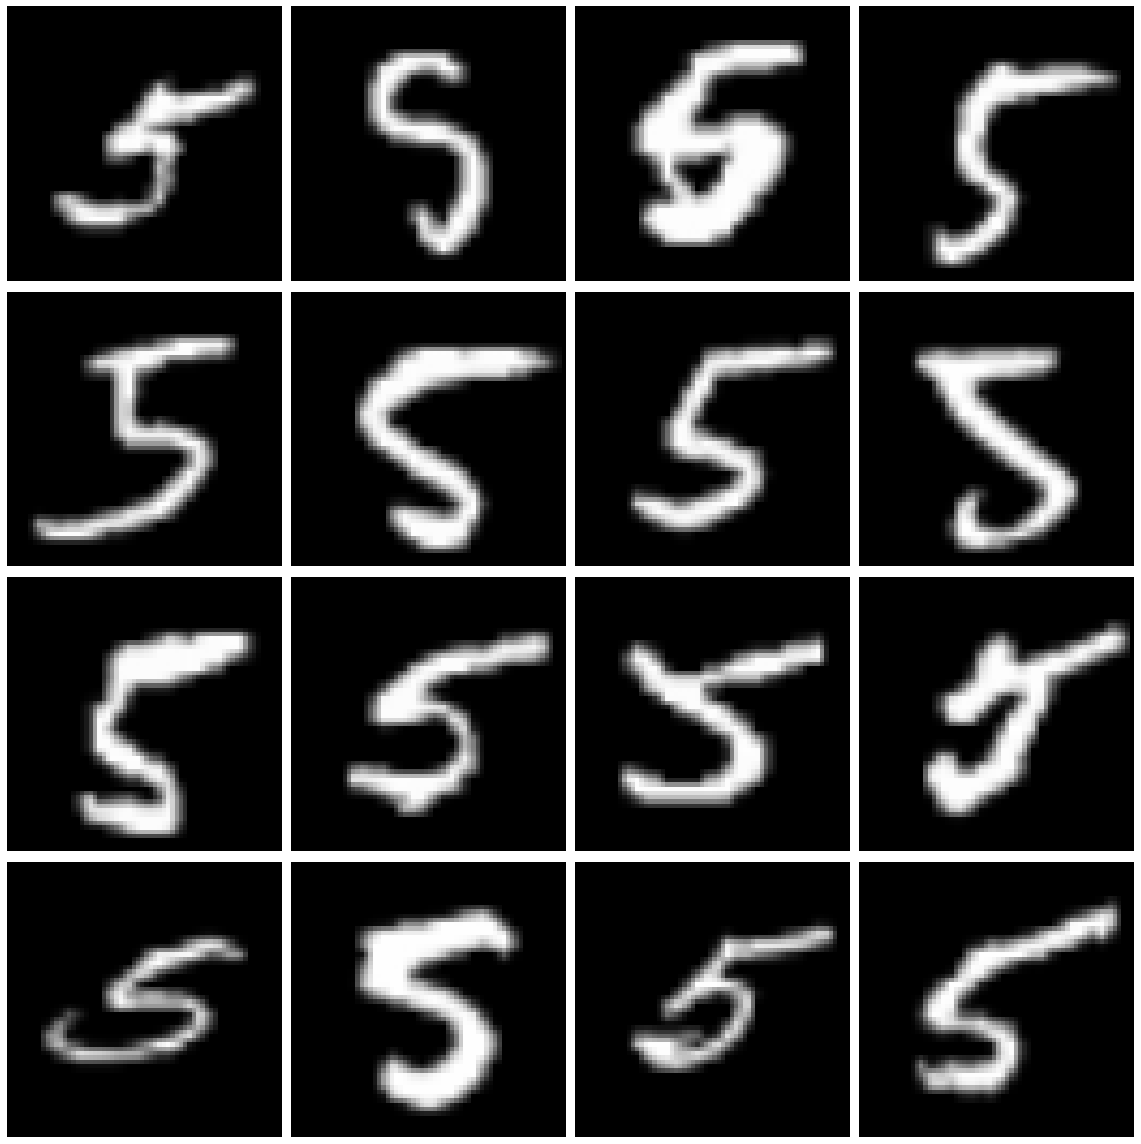

In [11]:
data.show_batch(rows=4)

In [12]:
generator = basic_generator(in_size=img_size, n_channels=3, noise_sz=noise_dim)
critic    = basic_critic   (in_size=img_size, n_channels=3)

In [13]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.174030,#na#,0.058094,-0.220473,00:05
1,-0.492295,#na#,0.249449,-0.640406,00:03
2,-0.820178,#na#,0.416955,-1.067303,00:03
3,-1.005437,#na#,0.523238,-1.319812,00:03
4,-1.087556,#na#,0.587231,-1.442039,00:03
5,-1.117122,#na#,0.626744,-1.493419,00:04
6,-1.125767,#na#,0.652669,-1.513181,00:03
7,-1.130175,#na#,0.671454,-1.523424,00:03
8,-1.132686,#na#,0.685349,-1.528934,00:03
9,-1.129921,#na#,0.694875,-1.526710,00:03


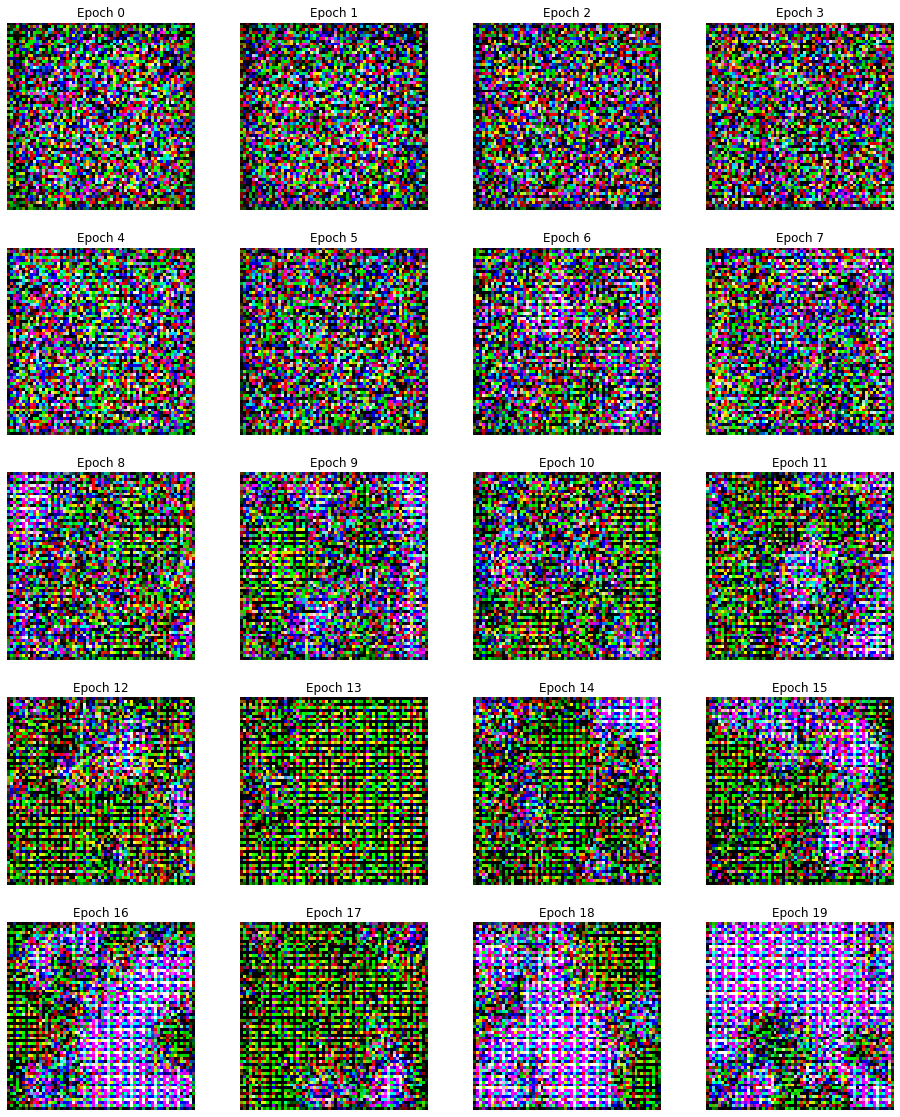

In [14]:
learn.fit_one_cycle(20, max_lr=1e-3)

# WGAN的生成效果如下

In [15]:
learn.gan_trainer.switch(gen_mode=True)

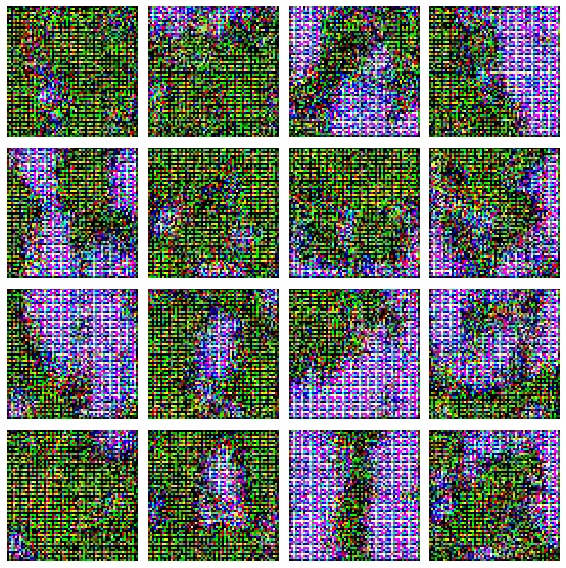

In [16]:
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(8,8))

分析一下就知道，我们的模型生成差的原因是，瞎子给瞎子指路。。。

In [17]:
learn.predict(data.train_ds[0][0])

(Image (3, 64, 64),
 tensor([[[ 0.1613, -0.1699, -0.1290,  ..., -0.2311,  0.3587, -0.2984],
          [ 0.5773, -0.7560, -0.7025,  ...,  0.3394, -0.1855, -0.3322],
          [ 0.0461, -0.0689, -0.9697,  ...,  0.8207, -0.1978, -0.0134],
          ...,
          [ 0.1633,  0.9407,  0.2106,  ...,  0.4459, -0.4288,  0.1701],
          [ 0.1031, -0.7838, -0.7627,  ..., -0.2918, -0.2253, -0.3791],
          [ 0.1612, -0.4064, -0.1212,  ..., -0.6463, -0.4897, -0.1703]],
 
         [[-0.2798, -0.5370, -0.2578,  ...,  0.2016, -0.0649,  0.1704],
          [ 0.2296, -0.6391, -0.9271,  ..., -0.5085,  0.9337, -0.6483],
          [-0.2354,  0.0301,  0.5600,  ..., -0.9191, -0.8622,  0.2734],
          ...,
          [-0.2709,  0.9962, -0.9755,  ...,  0.5602, -0.8012,  0.1239],
          [-0.0170, -0.4847, -0.9337,  ..., -0.9012,  0.7778,  0.2875],
          [ 0.3249,  0.7392, -0.7386,  ...,  0.6859,  0.1629,  0.1164]],
 
         [[-0.7101, -0.5816,  0.7248,  ...,  0.0393,  0.3882, -0.2597],
        

# 如何提升效果呢？

试一试不瞎子指路，效果如何?  
即使用预训练生成对抗网络来检测实验结果

## 准备数据

### 判别器预训练数据

In [18]:
class MyImageList(ImageList):
    def get(self, i):
        res = self.items[i]
        self.sizes[i] = res.size
        return res

In [45]:
def f(x):
    v = x.label
    del x.label #消除标签值
    return v
class MyImageDataBunch(ImageDataBunch):
    @classmethod
    def from_lists(cls, path, imgs, **kwargs):
        
        src = (MyImageList(imgs, path = path).split_by_rand_pct(0.3, 0). \
               label_from_func(f))
        return cls.create_from_ll(src, **kwargs)
    @classmethod
    def from_pair(cls,path, imgs, **kwargs):
        src = (MyImageList(imgs, path=path).split_by_rand_pct(0.3, 0). \
                                label_from_func(f))
        return cls.create_from_ll(src, **kwargs)

In [46]:
true = [open_image(w) for w in focus_imgs]
for t in true:
    t.label = 1

In [47]:
learn.predict(data.train_ds[0][0])

(Image (3, 64, 64),
 tensor([[[ 3.3757e-04,  1.8119e-03,  2.1004e-03,  ...,  1.8119e-03,
            2.1004e-03,  4.8657e-04],
          [ 2.6848e-03,  5.5492e-03,  5.9864e-03,  ...,  5.5492e-03,
            5.9864e-03,  2.5335e-03],
          [ 1.1190e-03,  4.2805e-03,  4.5922e-03,  ...,  4.2805e-03,
            4.5922e-03,  1.3516e-03],
          ...,
          [ 2.3268e-03,  5.6797e-03,  5.2362e-03,  ...,  5.6507e-03,
            6.0399e-03,  2.5803e-03],
          [ 4.4753e-04,  3.7531e-03,  3.8659e-03,  ...,  4.6026e-03,
            4.8126e-03,  1.5874e-03],
          [-1.8110e-04,  3.6039e-04,  6.6187e-04,  ...,  3.7180e-04,
            6.4382e-04, -1.5407e-04]],
 
         [[ 9.2720e-04,  2.5505e-03,  2.5857e-03,  ...,  2.5505e-03,
            2.5857e-03,  1.9002e-03],
          [ 2.6829e-03,  6.3038e-03,  7.0080e-03,  ...,  6.3038e-03,
            7.0080e-03,  3.0186e-03],
          [ 2.5128e-03,  5.8612e-03,  5.8582e-03,  ...,  5.8612e-03,
            5.8582e-03,  2.9492e-03],

In [48]:
fake = [learn.predict(data.train_ds[i][0])[0] for i in range(len(true))]

In [49]:
for t in fake:
    t.label = 0

In [50]:
critic_data = true + fake

In [51]:
assert all([isinstance(w, Image) for w in critic_data]) # make sure

In [52]:
critic_data[-2].shape

torch.Size([3, 64, 64])

In [53]:
critic_data[2].shape

torch.Size([3, 28, 28])

In [54]:
critic_databunch = MyImageDataBunch.from_lists(path, critic_data, size = img_size) # make sure picture is the same size

### 生成器数据

In [55]:
gene_data = [open_image(w) for w in focus_imgs]
gene_data = [w.apply_tfms([], size = img_size) for w in gene_data] # 改变图像尺寸 3*28*28 -> 3*64*64
noise_items = [Image(NoisyItem(noise_dim).data) for _ in range(len(gene_data))]
assert len(noise_items) == len(gene_data)
for t, v in zip(noise_items, gene_data):
    t.label = v

In [56]:
generate_databunch = MyImageDataBunch.from_pair(path, noise_items, bs = 16)

In [57]:
generate_databunch.train_ds[0]

(Image (100, 1, 1), Image (3, 64, 64))

## 生成器训练

In [58]:
def loss_f(a, b):
    a = a.view(-1).float()
    b = b.view(-1).float()
    assert a.shape == b.shape, f"{a.shape} {b.shape}"
    return F.l1_loss(a, b)
    
g_learner = Learner(generate_databunch, generator, loss_func=loss_f,)

In [60]:
g_learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,0.122612,0.119189,00:08
1,0.114759,0.117183,00:04
2,0.107319,0.120218,00:04
3,0.090731,0.124473,00:04
4,0.077648,0.127491,00:04
5,0.065527,0.127624,00:04
6,0.056336,0.127949,00:10
7,0.048839,0.129076,00:04
8,0.042941,0.128228,00:04
9,0.039915,0.129785,00:04


In [61]:
g_learner.data.single_ds

LabelList (1626 items)
x: MyImageList
Image (100, 1, 1),Image (100, 1, 1),Image (100, 1, 1),Image (100, 1, 1),Image (100, 1, 1)
y: ItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
Path: /home/liangjiaxi/.fastai/data/mnist_png/training/5

In [63]:
a = g_learner.predict(Image(NoisyItem(noise_dim).data))

In [71]:
[Image(w) for w in a]

[Image (3, 64, 64), Image (3, 64, 64), Image (3, 64, 64)]

In [72]:
g_learner.save('/tmp/g_learner')

In [73]:
g_learner = None
gc.collect()

3553

## 判别器训练 

In [84]:
critic_databunch.train_ds[-5:]

LabelList (5 items)
x: MyImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: /home/liangjiaxi/.fastai/data/mnist_png/training/5

In [101]:
def wrapper(func):
    def f(a, b):
        a = a.float()
        b = b.long()
        return func(a, b)
    return f
c_learner = Learner(critic_databunch, create_cnn_model(models.resnet18, 2), loss_func=wrapper(F.cross_entropy))

In [102]:
c_learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,0.051541,15.950852,00:06
1,0.022699,5.801229,00:06
2,0.027212,0.413941,00:06
3,0.023061,3.369132,00:06
4,0.003223,0.000024,00:06
5,0.002898,0.004816,00:06
6,0.002879,0.000023,00:05
7,0.000286,0.000010,00:05
8,0.000044,0.000006,00:06
9,0.000020,0.000005,00:06


In [103]:
c_learner.save('/tmp/c_learner')
c_learner = None
gc.collect()

36744

In [104]:
c_learner = Learner(critic_databunch, create_cnn_model(models.resnet18, 2))
g_learner = Learner(generate_databunch, generator, loss_func=loss_f,)

In [117]:
g_learner = g_learner.load('/tmp/g_learner')
c_learner = c_learner.load('/tmp/c_learner')
c_learner.loss_func = wrapper(F.cross_entropy)

In [118]:
# switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
# learn = GANLearner.from_learners(g_learner, c_learner, weights_gen=(1.,50.), show_img=False, switcher=switcher,
#                                  opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=0)
# learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [119]:
# 确保图片大小是2的幂次
data = GANItemList.from_folder(path, noise_sz=noise_dim) \
               .split_none()\
               .label_from_func(noop) \
               .transform(size = img_size, tfm_y=True) \
               .databunch(bs=18)

In [123]:
gan_learner = GANLearner.wgan(data, g_learner.model, c_learner.model, )

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,0.000293,#na#,0.001508,0.000024,00:04
1,0.000174,#na#,0.001146,-0.000008,00:06
2,0.000181,#na#,0.000980,0.000039,00:04
3,0.000096,#na#,0.000701,0.000038,00:04
4,0.000021,#na#,0.000563,-0.000023,00:04
5,0.000011,#na#,0.000448,-0.000016,00:04
6,0.000040,#na#,0.000395,0.000008,00:04
7,0.000031,#na#,0.000351,-0.000000,00:04
8,-0.000021,#na#,0.000288,-0.000027,00:07
9,0.000073,#na#,0.000318,0.000006,00:13


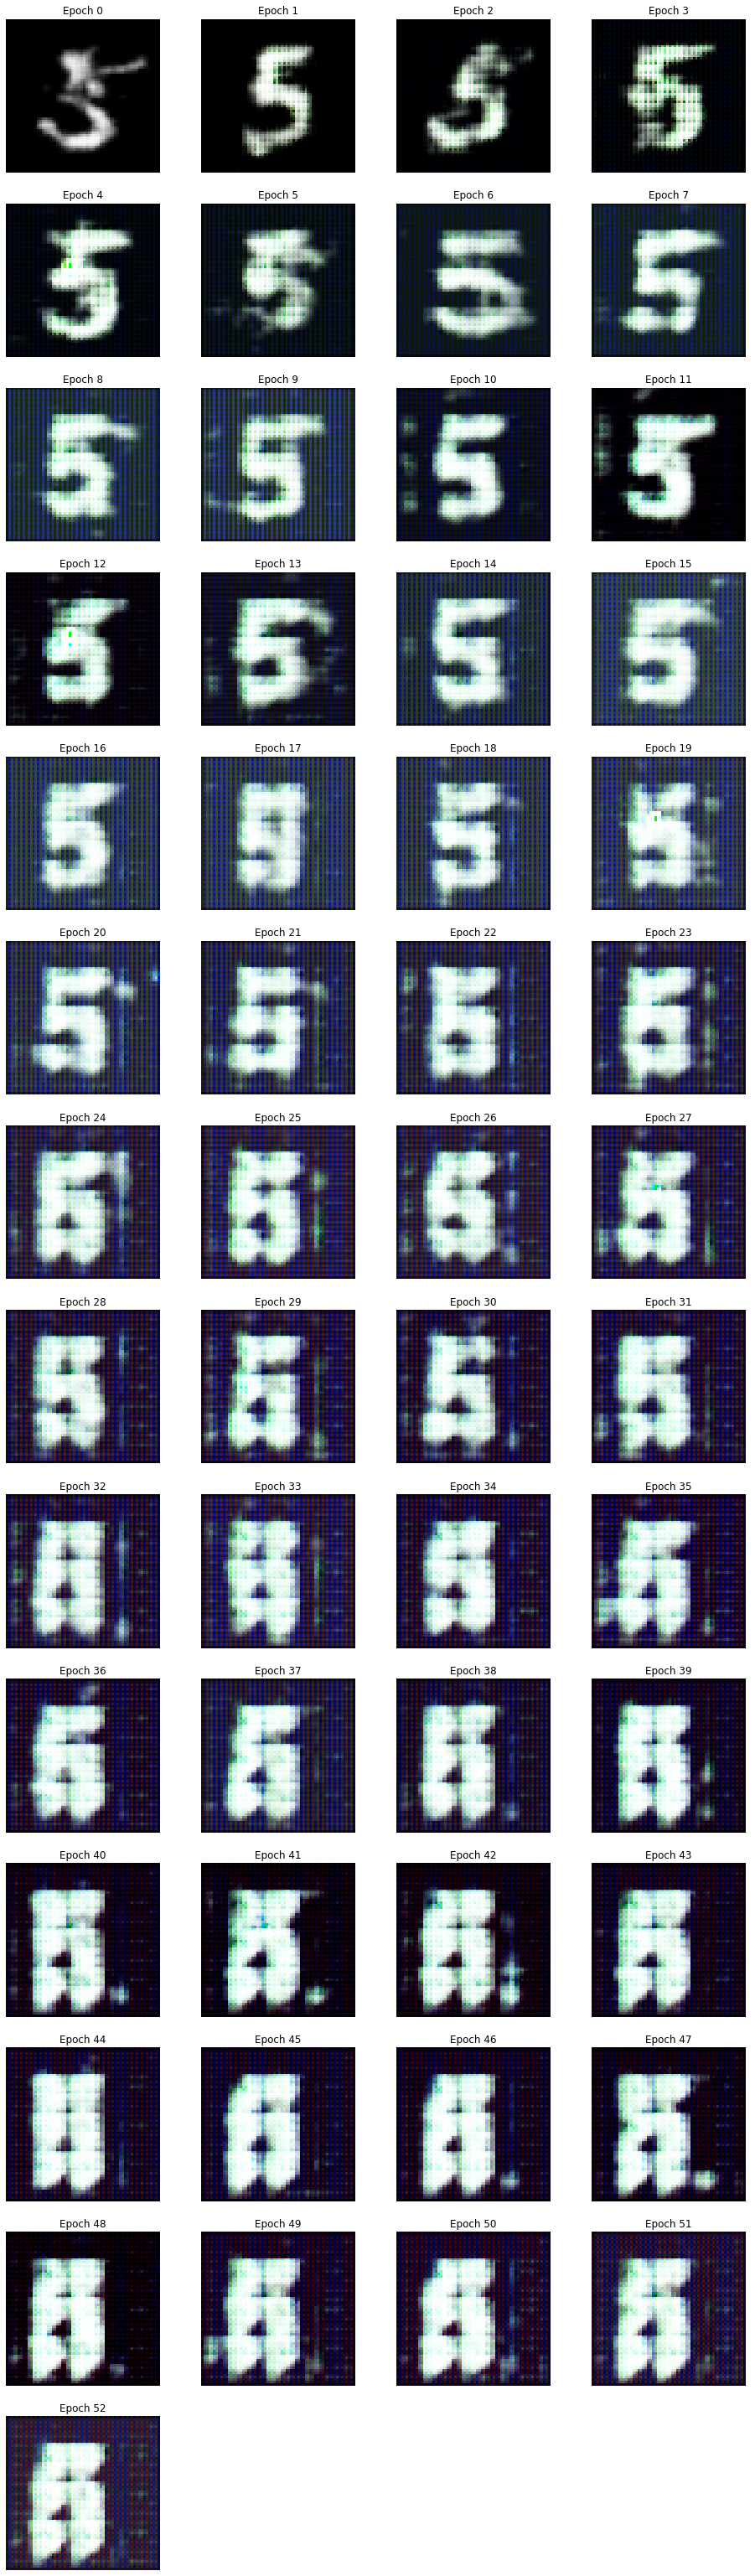

KeyboardInterrupt: 

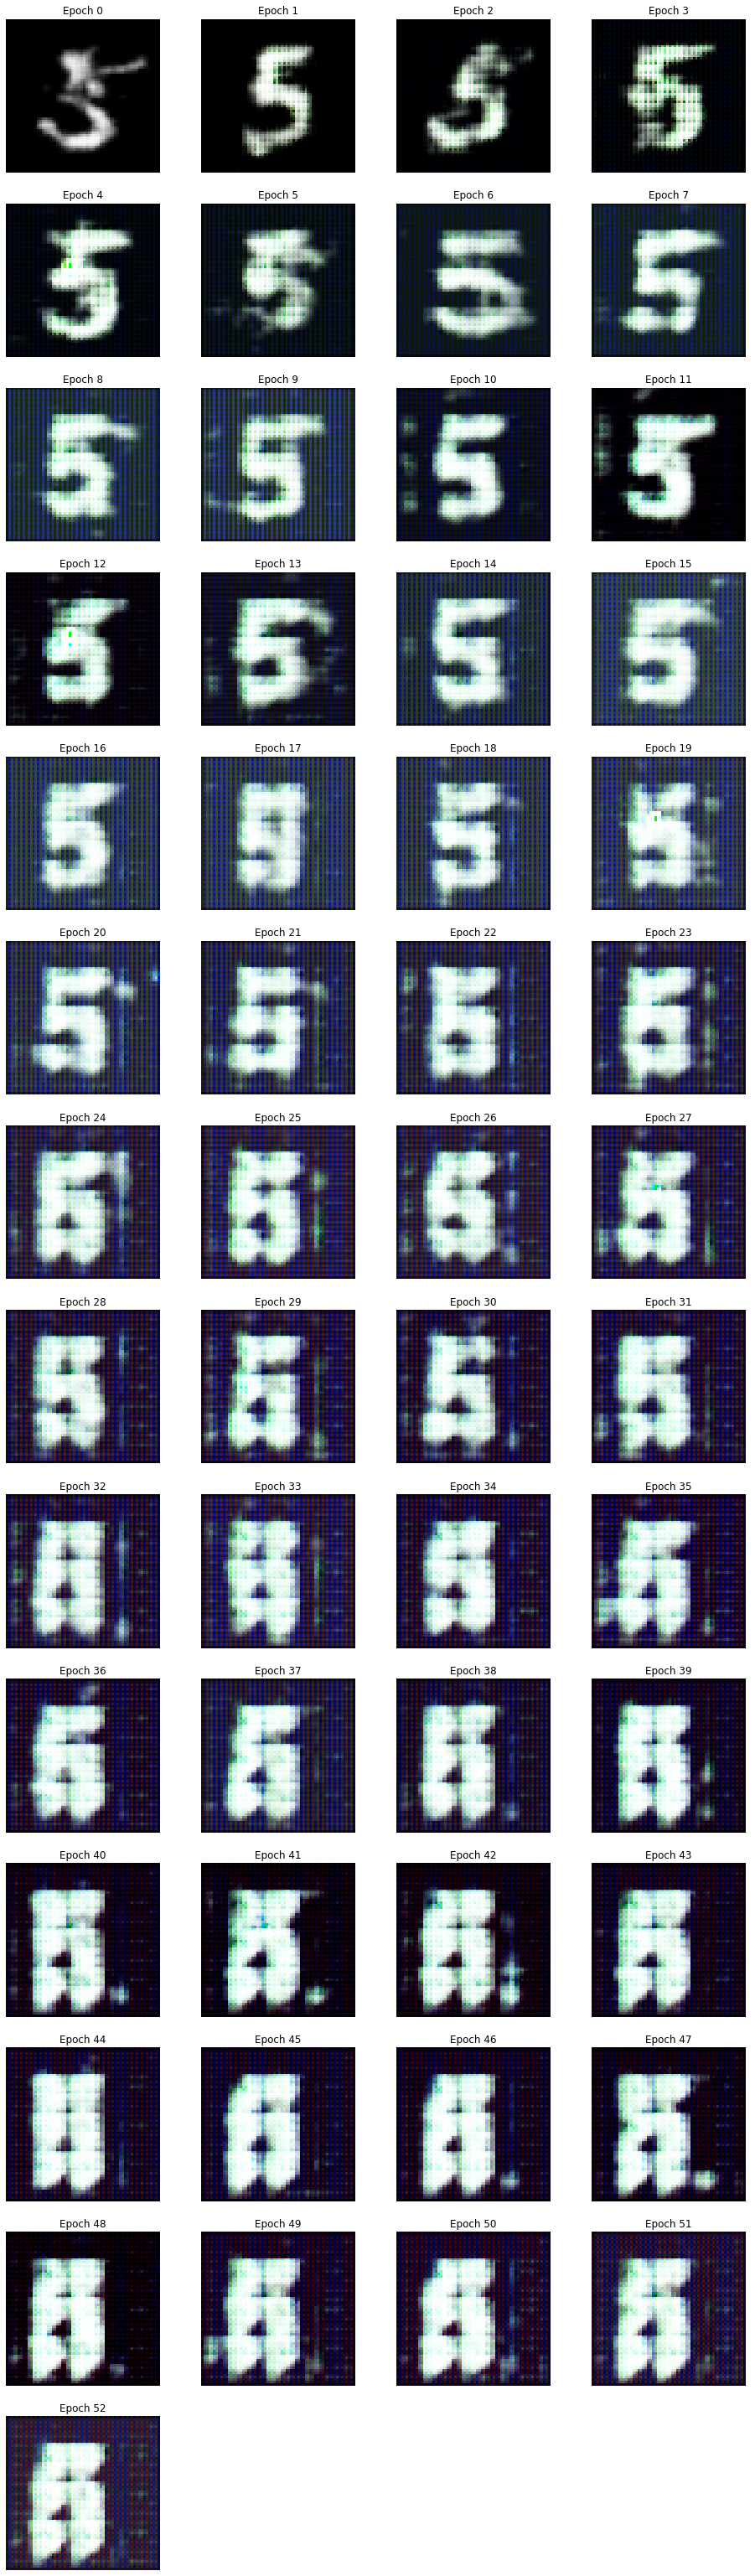

In [125]:
gan_learner.fit(40)